In [1]:
from biopandas.pdb import PandasPdb #libreria para trabajar con .PBD
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import scipy.fftpack as fourier
from scipy.spatial.distance import cdist
from itertools import combinations

# Crea un objeto "nodo" con atributos de índice, conexiones y estado

In [2]:
# Esta es la clase "nodo" que contiene tres atributos:
# i = el índice que este nodo ocupa en la red
# conex[] = una lista con los índices de los nodos a los cuales está conectado
# estado[] = estado inicial aleatorio, numero real y guarda en una lista los siguientes estados
class nodo():
    # Construye al nodo
    # Recibe como argumento el índice "i" que el nodo ocupa en la red
    def __init__(self,i,T):
        self.indice = i
        self.conex = [] #lista de conexiones
        self.estado = [0]*T # un estado por cada paso de tiempo
    # Añade una conexión ("link") al nodo
    # Recibe como argumento el índice "k" del nodo con el que se va a conectar
    def addLink(self,k):
        self.conex.append(k)
    
    # Regresa el i-esimo link de este nodo
    # Es decir, regresa el índice de la i-esima conexión de este nodo
    def getLink(self,i):
        return self.conex[i]
    
    # Regresa el número total de conexiones de este nodo
    def getK(self):
        return len(self.conex)
        
    # Asigna un estado a este nodo
    # Recibe como argumento el nuevo valor "w" del estado
    # y lo asigna al estado en tiempo i de este nodo   
    
    def setS(self,i,w):
        self.estado[i] = w   
    # Regresa el i-esimo estado de este nodo
    def getS(self,i):
        return self.estado[i] 
    #limpia la lista de estados
    #def limpiaS(self,i):
        #self.estado[i] = []
    

# Crea una red G en base a un archivo pdb

In [3]:
#crea una red  G en base a un archivo pdb 
def G_Pro(D, pdb_file):
    # Lee el archivo PDB y convierte los datos en un DataFrame
    
    df = PandasPdb().read_pdb(pdb_file)

    # Filtra solo los carbonos alfa y toma solo el primero de cada residuo
    df_ca = df.df['ATOM'][df.df['ATOM']['atom_name'] == 'CA']
    df_ca = df_ca.groupby('residue_number').first().reset_index()
    
    # Filtra los residuos que se van a omitir
    df_ca = df_ca[~df_ca['residue_number'].isin([1, 2]) & ~df_ca['residue_number'].between(301, 306)]

    # Calcula la matriz de distancia entre los carbonos alfa
    distances = cdist(df_ca[['x_coord', 'y_coord', 'z_coord']], df_ca[['x_coord', 'y_coord', 'z_coord']])

    # Encuentra las parejas de carbonos alfa que están a menos de 7 Ångstroms
    ca_combinations = combinations(range(len(distances)), 2)
    ca_pairs = [(df_ca.iloc[i]['residue_number']-3, df_ca.iloc[j]['residue_number']-3)
                for i, j in ca_combinations if distances[i][j] < D]

    # Obtener el número de nodos
    nodos = list(set(sum(ca_pairs, ())))
    num_nodos = len(nodos)

    # Crear una matriz de ceros de tamaño num_nodos x num_nodos
    matriz = np.zeros((num_nodos, num_nodos))

    # Llenar la matriz con las conexiones
    for conexion in ca_pairs:
        i = nodos.index(conexion[0])
        j = nodos.index(conexion[1])
        matriz[i][j] = 1
        matriz[j][i] = 1

    # Crea un objeto Graph de networkx y agrega los nodos y las aristas a partir de la matriz de adyacencia
    G = nx.Graph(matriz)

    # Imprimir el resultado
    print("El número de nodos de la red", pdb_file ,"es:", num_nodos)
    
    return G
 

# Crea la clase red con atributo nodos para guardar estados de las dinámicas  de mapeos acoplados y aplica diferentes herramientas de análisis dinámico 

In [111]:
# Esta es la clase "red" 
# Como atributos sólamente tiene una lista "nd" de nodos
class redPro():
    # Construye a la red
    # hace uso del objeto "nodo" el cual puede guardar estados, esto para la dinamica CML
    def __init__(self,N,G,T,pdb_file):
        
        #lista de nodos inicialmente vacía
        self.nd = []
        
        #número total de conexiones o aristas para la i-esima red G
        L = len(G.edges())
    
        # construye N nodos con T estados y se añaden uno por uno al arreglo "nd" de nodos
        for i in range(0,N):
            self.nd.append(nodo(i,T))   
      
        # Se establecen L conexiones entre los N nodos en la red G   
        for i in range(0,L):
            # Seleccionamos una pareja i (0,1) de la red G
            # Añadimos 0 al nodo 1 y viceversa del eje i
            self.nd[list(set(G.edges))[i][0]-1].addLink(list(set(G.edges))[i][1]-1) 
            self.nd[list(set(G.edges))[i][1]-1].addLink(list(set(G.edges))[i][0]-1)

            
        # ------------------------------   
        # Listo! La red está construida
        # ------------------------------
        #Método para asignar los estado iniciales de los nodos en la red entre (0,1)
        w = [0]*N 
        for i in range(0,N):
            w[i]=np.random.uniform(0, 1)
            self.nd[i].setS(0,w[i])     
        
    #Mapa Logistico    
    def Logistic(self,R,x):
        L = R*x*(1-x)
        return L   
    #Mapa Logistico Aux para DMCL
    def LogisticAux(self,eps):
        eps = 3.99*eps*(1-eps)
        return eps 
  
   
     #Método para reiniciar los estados de los nodos en la red
    def Reiniciar_Estados(self):
        w = [0]*N 
        for i in range(0,N):
            w[i]=np.random.uniform(0, 1)
            self.nd[i].setS(0,w[i])     
    def CML(self, N,eps, R, T): #Mapeo Logistico  
        st = [0]*N  # lista temporal para guardar los estados actualizados de 
                # los nodos en cada paso de tiempo. Esto es para no afectar
                # el estado de los nodos "reales" antes de haber revisado
                # todos los nodos en la red
            
        for j in range(0,T): #pasos de tiempo
                             # Copiamos los estados de los nodos a la lista temporal st[]
                    
            for i in range(0,N):
                st[i] = self.nd[i].getS(j)
                # pasos de tiempo discretos de 0 a T-1 
                # mepeo acoplado sobre cada nodo 
            for i in range(0,N):
                suma = 0
                k = self.nd[i].getK() #conexiones del nodo 
                for n in range(k):  
                    ki = self.nd[i].getLink(n)
                    suma+= self.Logistic(R,self.nd[ki].getS(j)) 
                if tipoMap == "CML": 
                    eps = eps
                elif tipoMap == "DCML":    
                    eps= self.LogisticAux(eps)    
                st[i] = (1-eps)*self.Logistic(R,st[i]) + eps*suma/(k)
             #print(st) Esto es una prueba
             # Ya recorrimos todos los nodos de la red y actualizamos sus estados 
             # Los estados actualizados se guardaron en el arreglo temporal st[]
             # Ahora copiamos los estados n-esimos a los nodos "verdaderos" de la red
            for i in range(0,N):
                    self.nd[i].setS(j+1,st[i])   
    #Grafica la red      
    def GraphNetwork(self,G):
        # Crear un mapeo para la nueva numeración de los nodos
        mapping = {n: n + 3 for n in G.nodes()}

        # Obtener la red con la numeración de los nodos modificada
        red_numerada = nx.relabel_nodes(G, mapping)
        
        plt.figure(figsize=(18, 18))
        nx.draw_kamada_kawai(red_numerada, node_size=200, cmap=plt.cm.jet, node_color="darkcyan", width=0.4, font_size=8, with_labels=True, font_color="Black")

        #plt.figure(figsize=(20,20))
        #nx.draw_kamada_kawai(G,node_size = 50,cmap=plt.cm.hsv,node_color="darkcyan",edge_color="blue", width=1.5)
        if save_graph.lower() == 'y':
            plt.savefig(f"Red {pdb_file} D={D}.png", dpi=200)
        plt.show()
    # ========================================================================
    
    def PlotEini(self):    #Graficamos los estados iniciales
        l = [0]*N        
        e = [0]*N
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,N):
            l[i] = i + 3 # se suma 3 para hacer coincidir los residuos con los nodos
            k = self.nd[i].getS(0)
            e[i] = k
   
        x = np.array(l)
        p = np.array(e)
        plt.ylabel('Estado inicial $X_0 (Ni)$',size=16)
        plt.xlabel('Residuo (Ni)',size=16)
        plt.scatter(x,p,marker="o", color="red") 
        plt.ylim(0,1)
        plt.xlim(0,302)
        plt.show()
    # ========================================================================
    
    def PlotEfin(self,T):    #Graficamos los estados en tiempo T
        l = [0]*N        
        e = [0]*N
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,N):
            l[i] = i + 3 # se suma 3 para hacer coincidir los residuos con los nodos
            k = self.nd[i].getS(T-1)
            e[i] = k
   
        x = np.array(l)
        p = np.array(e)
        plt.ylabel(f"Estado al tiempo {T} $X_t (Ni)$",size=16)
        plt.xlabel('Residuo (Ni)',size=16)
        plt.scatter(x,p,marker="o", color="red")  
        plt.ylim(0,1)
        plt.xlim(0,302)
        plt.show()
    # ========================================================================
        
    def bifurcaciones(self,N,eps,T,Ni): # Grafica de orbitas de Ni
        x = [0]*T  # lista temporal para guardar los estados actualizados de 
                # los nodos en cada paso de tiempo. Esto es para no afectar
                # el estado de los nodos "reales" antes de haber revisado
                # todos los nodos en la red
        p = []
        ri = []
        Rs = np.linspace(3.4,4,1000) 
        plt.figure(figsize=(15,10)) 
        plt.grid()
        A = 50 #interaciones finales tomadas en cuenta
        for Ri in range(len(Rs)):
            self.Reiniciar_Estados()
            self.CML(N,eps, Rs[Ri], T)
            for i in range(T - A,T):
                x[i] = self.nd[Ni].getS(i)    
                #round(x[Ni], 1)
                if x[i] not in p: #quita los valores repetidos
                    p.append(x[i])
                    ri.append(Rs[Ri])

        plt.scatter(ri,p,marker=".", color = 'Red',s=1) 
        plt.ylim(0,1)
        plt.xlim(3.4,4)
        plt.title(f"Diagrama de Bifurcación residuo {Ni+3} {pdb_file} D={D} ({tipoMap}) $\epsilon = {eps} $",size=16)  
        plt.ylabel('$X_t (Ni)$',size=16)
        plt.xlabel('$R$',size=16)     
        if save_graph.lower() == 'y':
            plt.savefig(f"Diagrama de Bifurcación red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()
    # ========================================================================
    
   
    def SerieTiempoProm(self):   # Grafica la serie de tiempo promedio  
        l = [0]*T       
        e = [0]*T
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,T):
            l[i] = i
            for j in range(0,N):
                k = self.nd[j].getS(i)
                e[i] = e[i]+k
            e[i] = e[i]/N   

        x = np.array(l)
        p = np.array(e)
        plt.xlim(T*.9,T)
        plt.title(f"Series de Tiempo Promedio {tipoMap} $R = {R} $ $\epsilon = {eps} $ red {pdb_file} ",size=16)
        plt.ylabel(f" $X_t$",size=16)
        plt.xlabel('t',size=16)
        plt.plot(x,p, marker = '.',label= "Series de tiempo",color='turquoise')  
        plt.legend(prop = {'size': 16}, loc="lower right")
        if save_graph.lower() == 'y':
            plt.savefig(f"Series de tiempo promedio red {pdb_file} D={D} ({tipoMap}) eps={eps}-R={R}.png", dpi=200)
        plt.show() 
    # ========================================================================   
        
        
    def SerieTiempo(self,Ni):    #serie de tiempo de Ni
        l = [0]*T       
        e = [0]*T
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,T):
            l[i] = i
            k = self.nd[Ni].getS(i)
            e[i] = k
               

        x = np.array(l)
        p = np.array(e)
        plt.xlim(T*.9,T)
        plt.title(f"Series de Tiempo {tipoMap} $R = {R} $ $\epsilon = {eps} $ $Ni = {Ni+3} $ ",size=16)
        plt.ylabel(f" $X_t (Ni)$",size=16)
        plt.xlabel('t',size=16)
        plt.plot(x,p, marker = '.',label= "Series de tiempo",color='turquoise')  
        if save_graph.lower() == 'y':
            plt.savefig(f"Series de tiempo de Ni = {Ni+3} {pdb_file} D={D} ({tipoMap}) eps={eps}-R={R}.png", dpi=200)
        plt.show() 
    # ========================================================================   

    def Tfourier(self):    #T de fourier prom
        l = [0]*T       
        e = [0]*T
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,T):
            l[i] = (i-T/2)/1000
            for j in range(0,N):
                k = self.nd[j].getS(i)
                e[i] = e[i]+k
            e[i] = e[i]/N   

        x = np.array(l)
        p = np.array(e)
        pf = abs(fourier.fft(p))
        plt.xlim(-(T/2)/1000,(T/2)/1000)
        plt.ylim(0,40)
        plt.title(f"Espectro Frecuencias Promendio $R = {R} $ $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel('Espectro',size=16)
        plt.xlabel('Frecuencia Hz',size=16)
        plt.plot(x,pf,color='blue')    
        if save_graph.lower() == 'y':
            plt.savefig(f"Espectro Frecuencias promedio red {pdb_file} D={D} ({tipoMap}) eps={eps}-R={R}.png", dpi=200)
        plt.show()  
    # ========================================================================   
        
        
    def TfourierNi(self,Ni):    #T de fourier nodo Ni
        l = [0]*T       
        e = [0]*T
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for i in range(0,T):
            l[i] = (i-T/2)/1000
            k = self.nd[Ni].getS(i)
            e[i] = k  

        x = np.array(l)
        p = np.array(e)
        pf = abs(fourier.fft(p))
        plt.xlim(-(T/2)/1000,(T/2)/1000)
        plt.ylim(0,40)
        plt.title(f"Espectro Frecuencias $R = {R} $ $\epsilon = {eps} $ $Ni = {Ni+3} $ {tipoMap}",size=16)
        plt.ylabel('Espectro',size=16)
        plt.xlabel('Frecuencia Hz',size=16)
        plt.plot(x,pf,color='blue')   
        if save_graph.lower() == 'y':
            plt.savefig(f"Espectro Frecuencias de Ni = {Ni+3} red {pdb_file} D={D} ({tipoMap}) eps={eps}-R={R}.png", dpi=200)
        plt.show() 
    # ========================================================================   

   
    def AmplitudEspacioTemporal(self):    #Amplitud Espacio-Temporal  
        l = [0]*N        
        e = [0]*N
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for t in range(950,T): #descarto los primeros 50 pasos de tiempo (transitorios)
            for i in range(0,N):
                l[i] = i+3
                k = self.nd[i].getS(t)
                e[i] = k

            x = np.array(l)
            p = np.array(e)
            
            plt.ylabel('X(Ni)')
            plt.xlabel('Ni')
            plt.scatter(x,p) 
       
        plt.title(f"Amplitud Espacio-Temporal $R = {R} $ $\epsilon = {eps} $  {tipoMap}",size=16)  
        plt.ylabel('$X_t (Ni)$',size=16)
        plt.xlabel('Residuo $Ni$',size=16)    
        plt.ylim(0,1)
        plt.xlim(0,302)
         
        if save_graph.lower() == 'y':
            plt.savefig(f"Amplitud Espacio-Temporal T = {T-950} $R = {R} {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()   
    # ========================================================================
        
        
    def count_unique_elements(self): # Cuenta la cantidad de estados alcanzados por cada nodo de la red
        l = [0]*N
        plt.figure(figsize=(15,10))
        plt.grid()
        unique_values = []
        for i in range(N):
            unique_values.append(set())  # Creamos una lista de conjuntos vacíos
        for t in range(950,T):
            for i in range(N):
                l[i] = i+3
                k = self.nd[i].getS(t)
                unique_values[i].add(round(k, 4))  # Agregamos el valor a la lista de valores únicos de ese índice

        x = np.array(l)
        y = np.array([len(valores) for valores in unique_values])  # Obtenemos la cantidad de valores únicos por índice
        plt.title(f"Estados diferentes T = {T}  $R = {R} $ $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel('Cantidad de Orbitas',size=16)
        plt.xlabel('Residuo Ni',size=16)
        plt.plot(x, y,'bo-')
        plt.xlim(0,302)
        if save_graph.lower() == 'y':
            plt.savefig(f"Cantidades de estados red T = {T-950} $R = {R} {pdb_file} D={D} ({tipoMap}) eps={eps} R={R}.png", dpi=200)
        plt.show()
    # ======================================================================== 

    
    def AmplitudEspacioTemporalM(self,M):    #Amplitud Espacio-Temporal de M simulaciones
        plt.figure(figsize=(15,10)) 
        plt.grid()
        for m in range(0,M): #REPETICIONES
            self.Reiniciar_Estados()
            self.CML(N,eps, R, T)
            l = [0]*N        
            e = [0]*N
            
            for t in range(950,T): #descarto los primeros 50 pasos de tiempo (transitorios)
                for i in range(0,N):
                    l[i] = i+3
                    k = self.nd[i].getS(t)
                    e[i] = k

                x = np.array(l)
                p = np.array(e)

                plt.ylabel('X(Ni)')
                plt.xlabel('Ni')
                plt.scatter(x,p) 
        plt.title(f"Amplitud Espacio-Temporal T = {T} {M}-simulaciones $R = {R} $ $\epsilon = {eps} $  {tipoMap}",size=16)  
        plt.ylabel('$X_t (Ni)$',size=16)
        plt.xlabel('Residuo $Ni$',size=16)    
        plt.ylim(0,1) 
        plt.xlim(0,302)
        if save_graph.lower() == 'y':
            plt.savefig(f"Amplitud Espacio-Temporal T = {T-950} $R = {R} {M}-simulaciones red {pdb_file} D={D} ({tipoMap}) eps={eps} R={R}.png", dpi=200)
        plt.show() 
    # ======================================================================== 
    
    def count_unique_elements_m(self,M): # Cuenta la cantidad promedio de estados alcanzados por cada nodo de la red de M dinamicas
        plt.figure(figsize=(15,10))
        plt.grid()
        unique_values = []
        for i in range(N):
            unique_values.append(set())  # Creamos una lista de conjuntos vacíos
        for m in range(0,M): #REPETICIONES
            self.Reiniciar_Estados()
            self.CML(N,eps, R, T)
            l = [0]*N
            
            for t in range(950,T):
                for i in range(N):
                    l[i] = i+3
                    k = self.nd[i].getS(t)
                    unique_values[i].add(round(k, 4))  # Agregamos el valor a la lista de valores únicos de ese índice

        x = np.array(l)
        y = np.array([len(valores) for valores in unique_values])  # Obtenemos la cantidad de valores únicos por índice
        plt.title(f"Estados diferentes T = {T} {M}-simulaciones $R = {R} $ $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel('Cantidad de Orbitas',size=16)
        plt.xlabel('Residuo Ni',size=16)
        plt.plot(x, y,'-o')
        plt.xlim(0,302) 
        if save_graph.lower() == 'y':
            plt.savefig(f"Cantidad de estados red T = {T-950} $R = {R} {pdb_file} {M}-simulaciones D={D} ({tipoMap}) eps={eps} R={R}.png", dpi=200)
        plt.show()
    # ======================================================================== 
    
    def LyapunovProm(self,N, eps, T): # Coeficiente de Lyapunov del Mapeo Promediado
        plt.figure(figsize=(15,10)) 
        plt.grid()
        lamda = []
        ri = []
        Rs = np.linspace(3.4,4.0,100) 
        for Ri in range(len(Rs)):
            self.Reiniciar_Estados()
            self.CML(N,eps, Rs[Ri], T)
            L = 0
            Suma = 0      
            for n in range(0,N):
                Suma = 0

                for t in range(0,T):
                    k = self.nd[n].getS(t)
                    Suma += np.log(abs(Rs[Ri]-2*Rs[Ri]*k))  
                if Suma > 0:
                    L+=Suma/T
            lamda.append(L/N)
            ri.append(Rs[Ri])
        #plt.ylim(-1,1)
        plt.xlim(3.4,4)
        plt.plot(ri,lamda, color = 'black',markersize=.1) 
        plt.title(f"Coeficiente de Lyapunov promedio  $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel(f"Lyapunov",size=16)
        plt.xlabel('Parámetro de Bifurcación R',size=16)                    
        if save_graph.lower() == 'y':
            plt.savefig(f"Coeficiente de Lyapunov Promedio red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show() 
    # ========================================================================   

        
    def Lyapunov_n(self,N,Ni,eps,T): # lyapunov para el residuo Ni
        plt.figure(figsize=(15,10)) 
        plt.grid()
        lamda = []
        ri = []
        Rs = np.linspace(3.4,4,100) 
        for Ri in range(len(Rs)):
            self.Reiniciar_Estados()
            self.CML(N,eps, Rs[Ri], T)
            L = 0
            Suma = 0

            for t in range(0,T):
                k = self.nd[Ni].getS(t)
                Suma += np.log(abs(Rs[Ri]-2*Rs[Ri]*k))  
            if Suma > 0:
                L+=Suma/T
            lamda.append(L)
            ri.append(Rs[Ri])
        #plt.ylim(-1,1)
        plt.xlim(3.4,4)
        plt.plot(ri,lamda, color = 'black',markersize=.1) 
        plt.title(f"Coeficiente de Lyapunov de Ni = {Ni+3}  $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel(f"Lyapunov",size=16)
        plt.xlabel('Parámetro de Bifurcación R',size=16)            
            
        if save_graph.lower() == 'y':
            plt.savefig(f"Coeficiente de Lyapunov de Ni={Ni+3} red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()  
    # ======================================================================== 
        
    def Lyapunov_n_M(self,N,Ni,M, eps, T): #lyapunov para el nodo Ni promedio de M copias del sistema
        plt.figure(figsize=(15,10)) 
        plt.grid()
        lamda = []
        ri = []
        Rs = np.linspace(3.4,4,100) 
        for Ri in range(len(Rs)):
            L = 0
            for m in range(0,M):
                self.Reiniciar_Estados()
                self.CML(N,eps, Rs[Ri], T)
                Suma = 0

                for t in range(0,T):
                    k = self.nd[Ni].getS(t)
                    Suma += np.log(abs(Rs[Ri]-2*Rs[Ri]*k))  
                if Suma > 0:
                    L+=Suma/T
            lamda.append(L/M)
            ri.append(Rs[Ri])
        #plt.ylim(0,.06)
        plt.xlim(3.4,4)
        plt.plot(ri,lamda, color = 'black',markersize=.1) 
        plt.title(f"Coeficiente de Lyapunov de Ni = {Ni+3} promedio de {M}-Simulaciones  $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel(f"Lyapunov",size=16)
        plt.xlabel('Parámetro de Bifurcación R',size=16)                     
        if save_graph.lower() == 'y':
            plt.savefig(f"Coeficiente de Lyapunov Promedio {M}-Simulaciones de Ni={Ni+3} red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()  
    # ======================================================================== 
        
    def Lyapunov_Prom_M(self,N,R,M,eps,T): #lyapunov promedio de M copias del sistema para un R dado
        plt.figure(figsize=(15,10)) 
        plt.grid()
        lamda = []
        ni = []        
        for n in range(0,N):
            L = 0
            for m in range(0,M):
                self.Reiniciar_Estados()
                self.CML(N,eps, R, T)
                Suma = 0

                for t in range(0,T):
                    k = self.nd[n].getS(t)
                    Suma += np.log(abs(R-2*R*k))  
                if Suma > 0:
                    L+=Suma/T
            lamda.append(L/M)
            ni.append(n+3)
        #plt.ylim(0,.06)
        plt.xlim(0,302)
        plt.plot(ni,lamda, color = 'black',markersize=.1) 
        plt.title(f"Coeficiente de Lyapunov promedio R={R} {M}-Simulaciones red $\epsilon = {eps} $  {tipoMap}",size=16) 
        plt.ylabel(f"Lyapunov",size=16)
        plt.xlabel('Residuo Ni',size=16)                       
        if save_graph.lower() == 'y':
            plt.savefig(f"Coeficiente de Lyapunov Promedio R={R} {M}-Simulaciones red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()   
    # ======================================================================== 
 
    def LyapunovKSED(self,N,T,X,Y):
    
        self.Reiniciar_Estados()
        self.CML(N,X, Y, T)
        lamda = 0
        L = 0
        for n in range(0,N):
            Suma = 0

            for t in range(0,T):
                k = self.nd[n].getS(t)
                Suma += np.log(abs(Y-2*Y*k))  
            Suma= np.where(Suma > 0, Suma,0)
            L+=Suma/T
        lamda=(L/N)
        return lamda

    def KSED(self,N, T): #Kolmogorov-Sinai Entropy Density
        plt.figure(figsize=(15,15)) 
        #plt.grid()
        Es = np.linspace(0,1,50) 
        Rs = np.linspace(3.4,4,60) 
        X,Y = np.meshgrid(Es,Rs)
        Z = self.LyapunovKSED(N,T,X,Y)
                
        ax = plt.axes(projection='3d') 
        ax.set_title(f"Kolmogorov-Sinai Entropy Density (KSED) mapeo {tipoMap}",fontsize=14,fontweight="bold")
        ax.set_xlabel(f"$\epsilon$")
        ax.set_ylabel("R")
        ax.set_zlabel("KSED")         
        ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
        #ax.view_init(25, -120)
        if save_graph.lower() == 'y':
            plt.savefig(f"Kolmogorov-Sinai Entropy Density (KSED) red {pdb_file} D={D} ({tipoMap}) eps={eps}.png", dpi=200)
        plt.show()  
       


# Crea la red PRN para un radio de corte D, y hace dinámicas CML.

In [112]:
T = 3000 #Pasos de tiempo
M = 10 # repetir la dinamica M veces
# coeficiente de acoplamiento eps [0,1] solo valido para el primer paso y para el mapeo auxiliar en el caso del DCML
eps = .1
# parametro de control R del mapeo 
R = 3.45 # zona de caos R >≈ 𝟑. 𝟓𝟔𝟗𝟗𝟒 (mapeo Logistico), 3.449 periodo 4

D = 7.0 # radio de corte para residuos 

pdb_file = '6y2e.pdb'

G = G_Pro(D,pdb_file) #red proteinas

N = len(G.nodes())

#G = nx.watts_strogatz_graph(n = N, k = 8, p = 0.0) #red SW

#G =  nx.complete_graph(N, create_using=None) #red completa

#G =  nx.cycle_graph(N) # Crear un grafo de anillo con N nodos

r = redPro(N,G,T+1,pdb_file)

#r.GraphNetwork(G)

tipoMap="DCML"  #Define el tipo de mapeo "CML" o "DCML"

r.CML(N,eps,R, T)

Ni = 28 - 3 # Resultado para un residuo (nodo-3) espacífico

# No guardar la gráficas por defecto
save_graph = 'n'

El número de nodos de la red 6y2e.pdb es: 298


In [113]:
# Preguntar si deseas guardar la gráfica
save_graph = input("¿Deseas guardar la gráfica? (y/n): ")

¿Deseas guardar la gráfica? (y/n): y


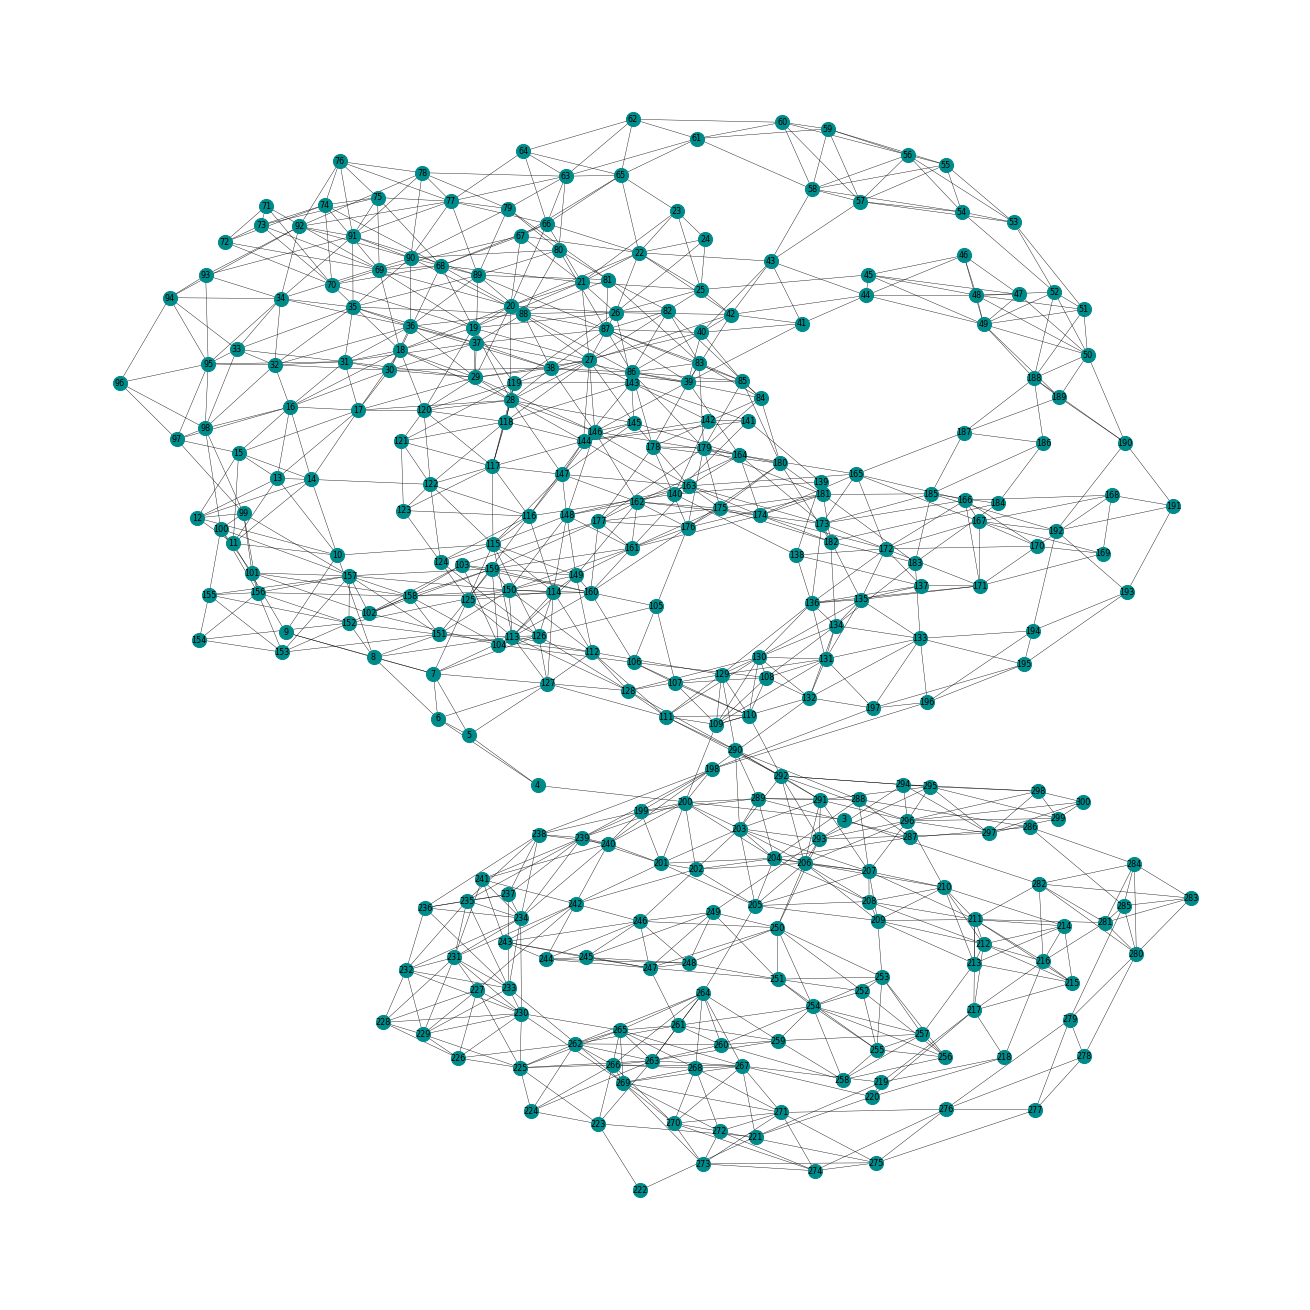

In [66]:
r.GraphNetwork(G)  #Grafica de la red

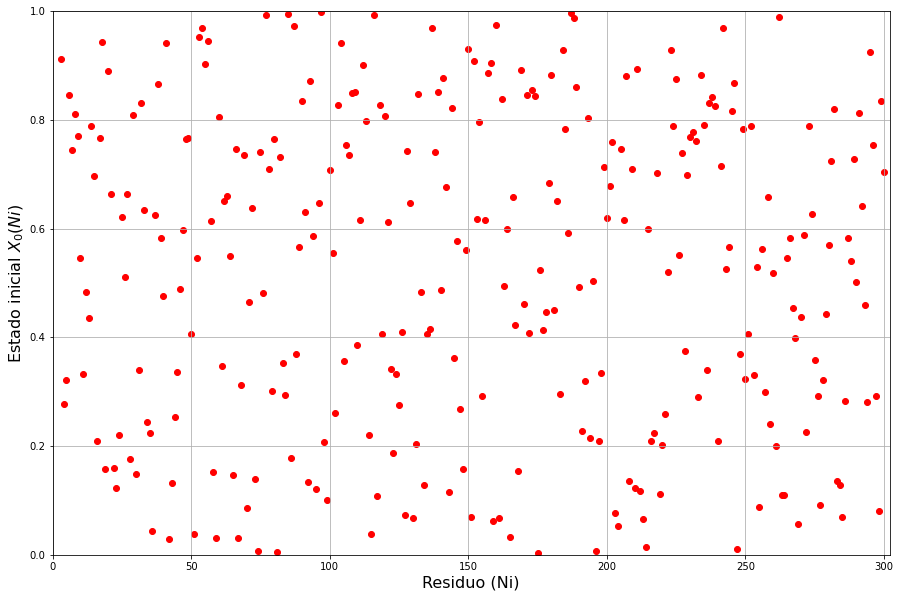

In [67]:
r.PlotEini()   #Graficamos los estados iniciales

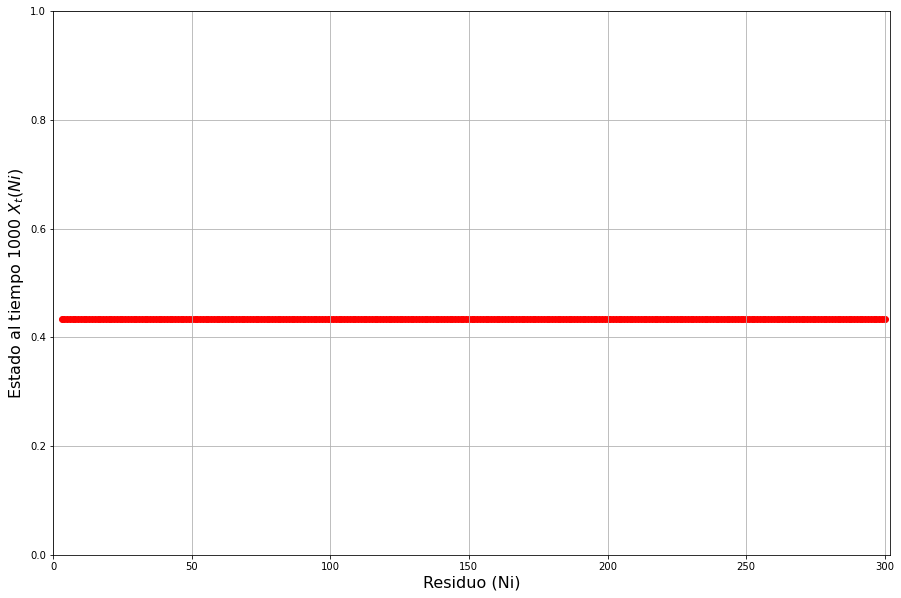

In [68]:
r.PlotEfin(1000)    #Graficamos los estados en tiempo T

## Series de tiempo

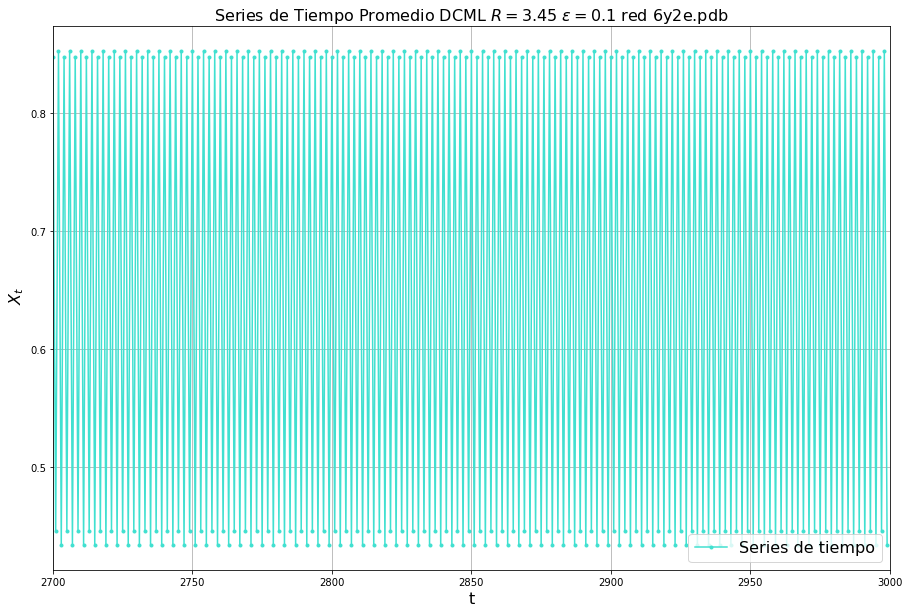

In [93]:
r.SerieTiempoProm() #serie de tiempo promedio

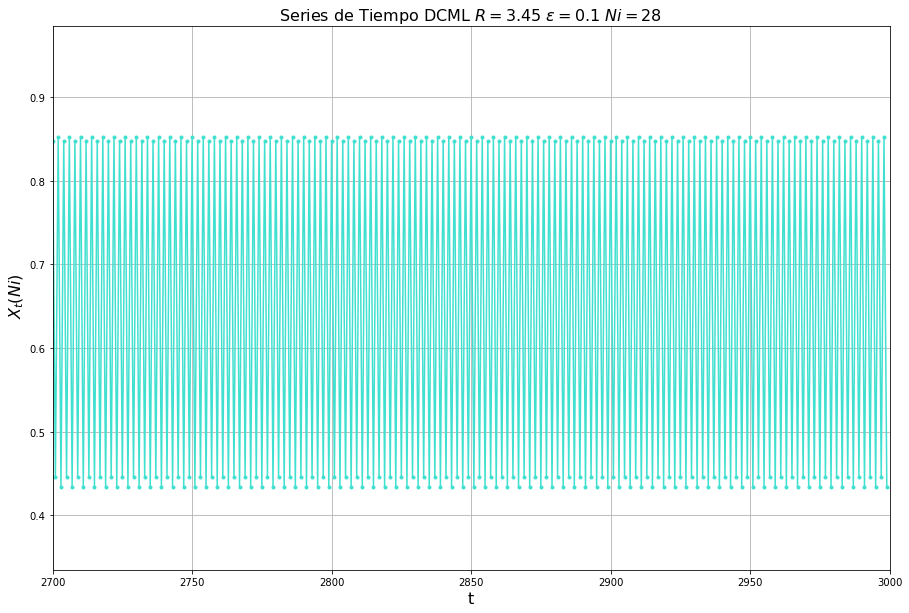

In [94]:
r.SerieTiempo(Ni) #serie de tiempo de Ni

## Diagrama de orbitas 

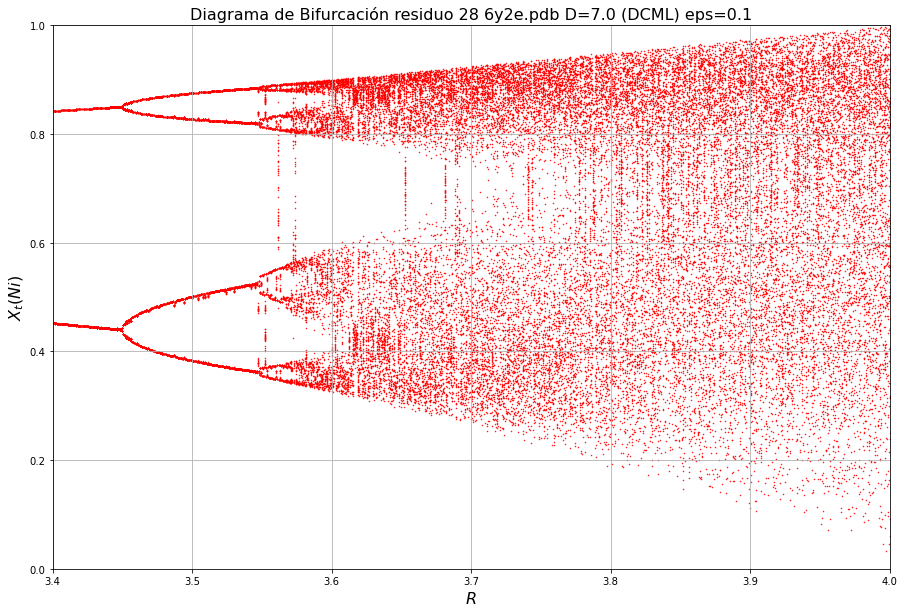

In [71]:
r.bifurcaciones(N,eps,1000,Ni) #bifurcaciones para el nodo (residuo) Ni 

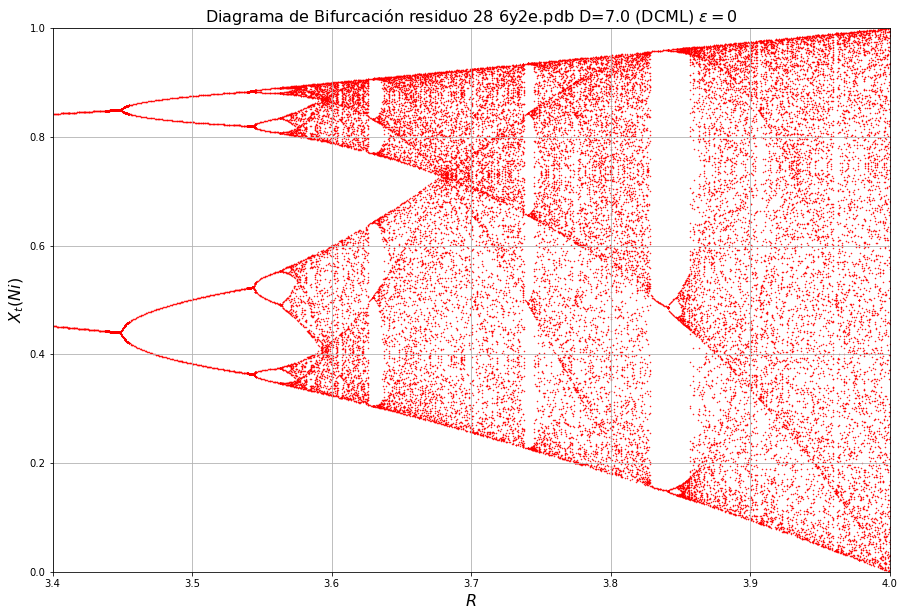

In [107]:
r.bifurcaciones(N,0,1000,Ni) #bifurcaciones para el nodo (residuo) Ni 

## Diagrama de Lyapunov

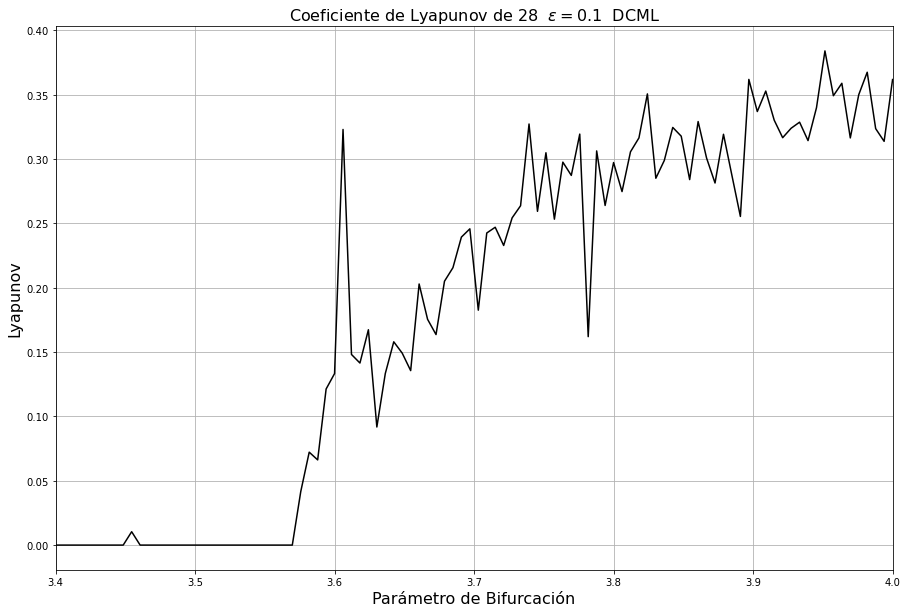

In [80]:
r.Lyapunov_n(N,Ni,eps,500) #lyapunov para el residuo Ni

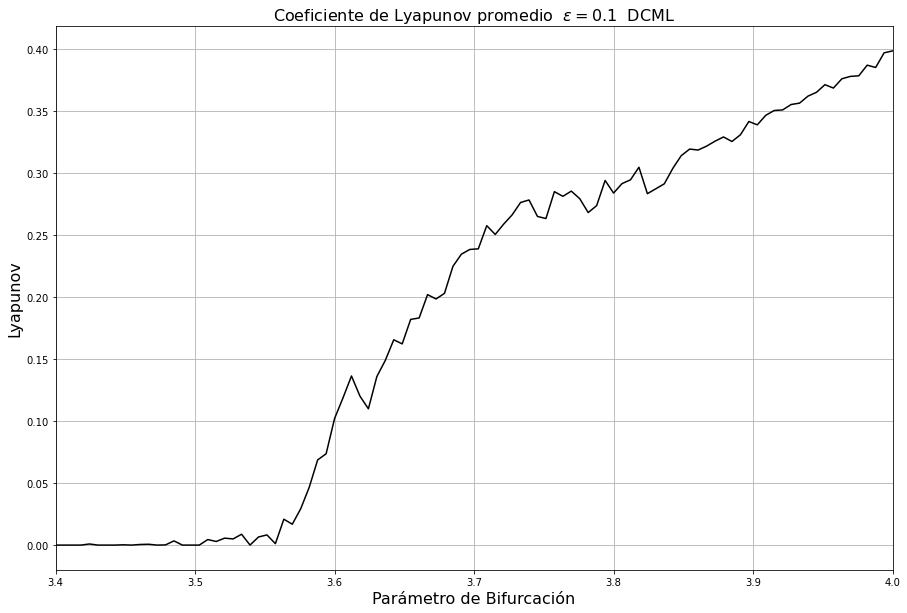

In [81]:
r.LyapunovProm(N,eps,500) # Coeficiente de Lyapunov del Mapeo Promediado

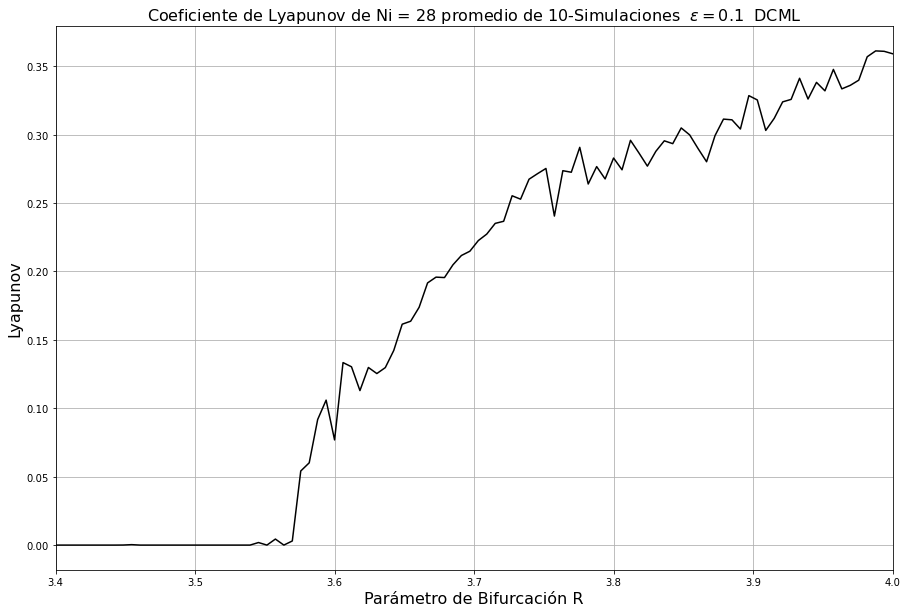

In [99]:
r.Lyapunov_n_M(N,Ni,10, eps, 500) #lyapunov para el nodo Ni promedio de M copias del sistema

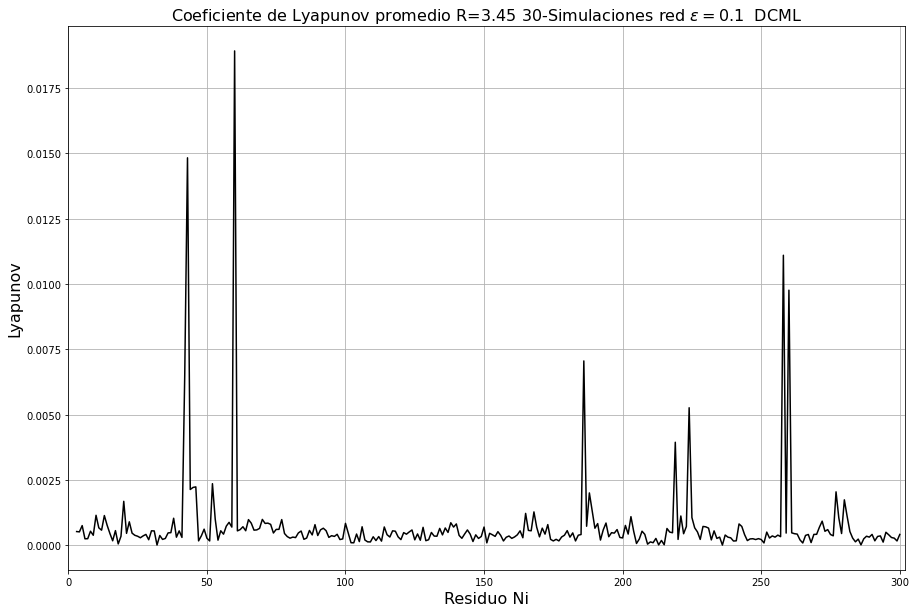

In [115]:
r.Lyapunov_Prom_M(N,R,30, eps, 1000) #lyapunov promedio de M copias del sistema para un R dado

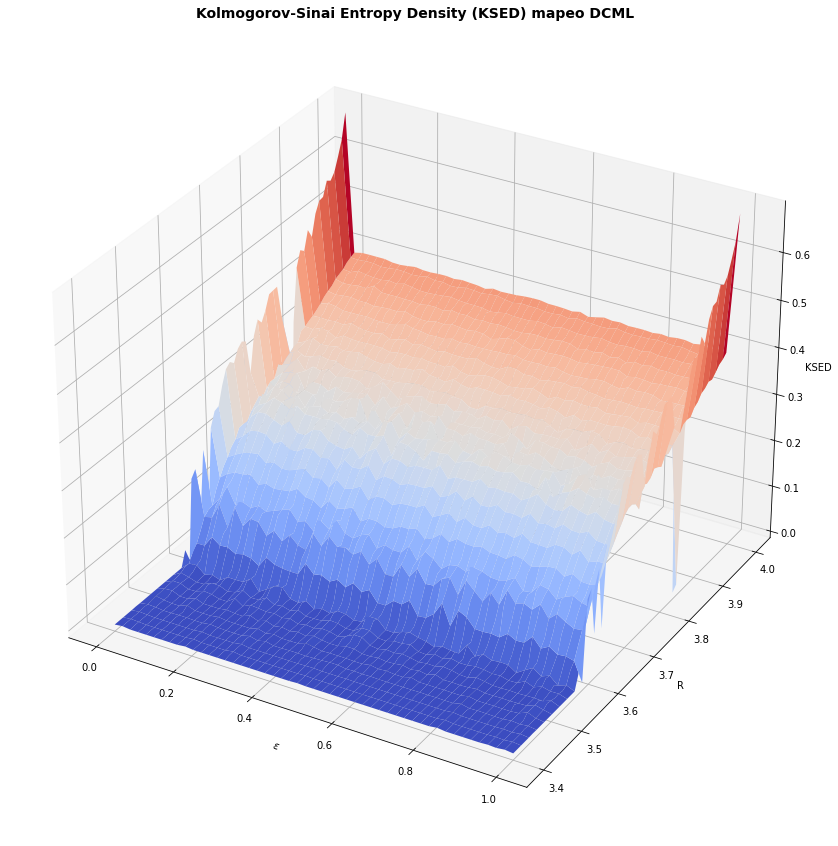

In [114]:
r.KSED(N,500)#3D densidad de entropia 

## Amplitud espacio temporal

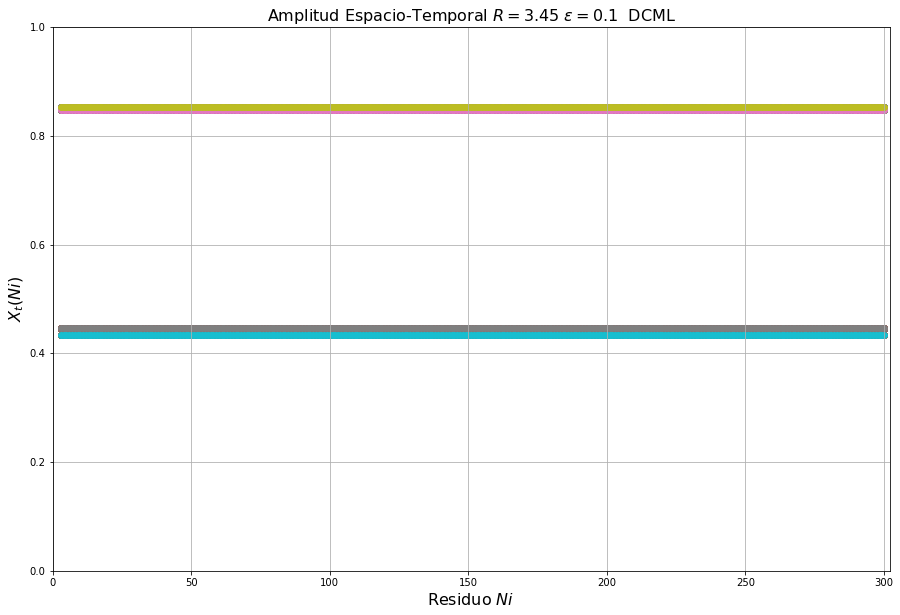

In [53]:
r.AmplitudEspacioTemporal() #Amplitud Espacio-Temporal

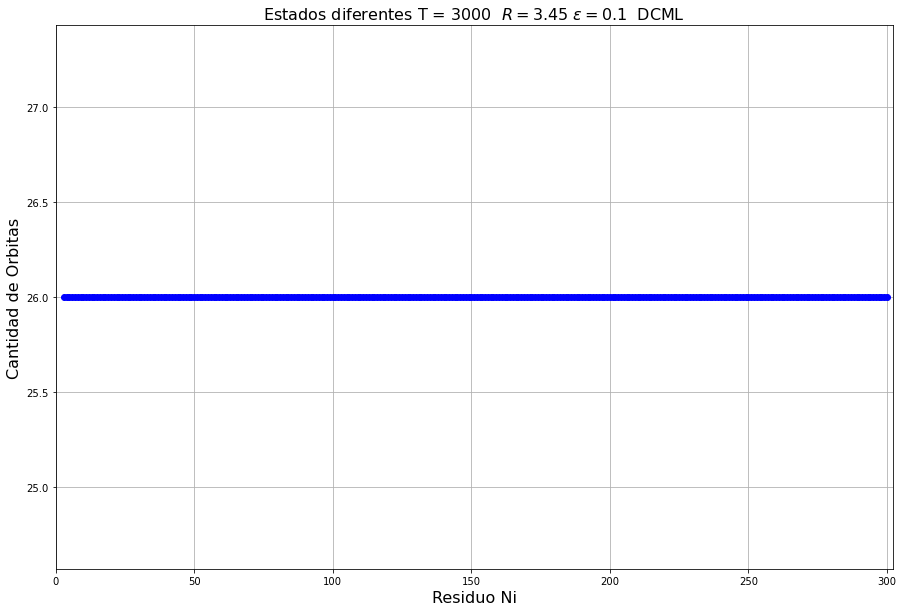

In [102]:
r.count_unique_elements() # Cuenta la cantidad de estados alcanzados por cada nodo de la red

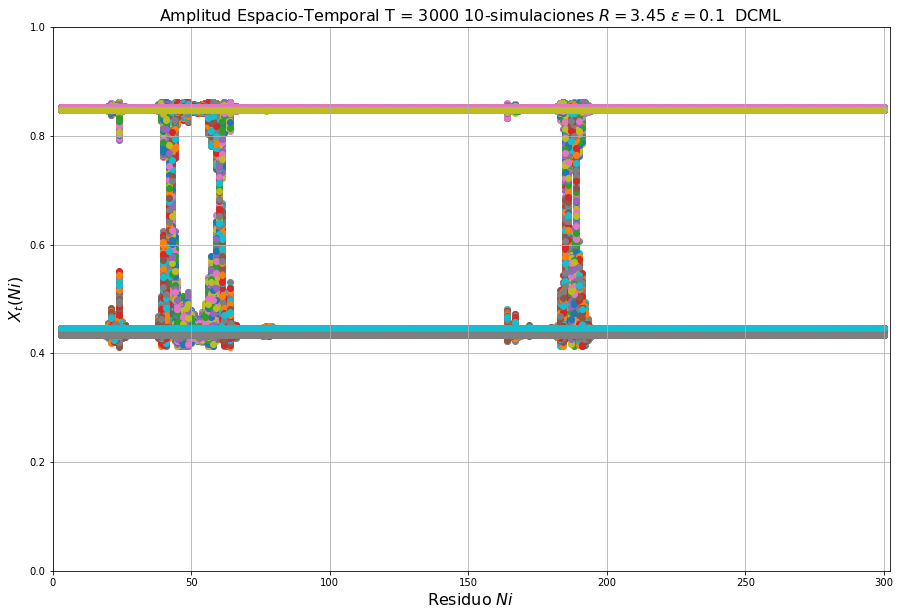

In [103]:
r.AmplitudEspacioTemporalM(10) #Amplitud Espacio-Temporal de M copias del sistema

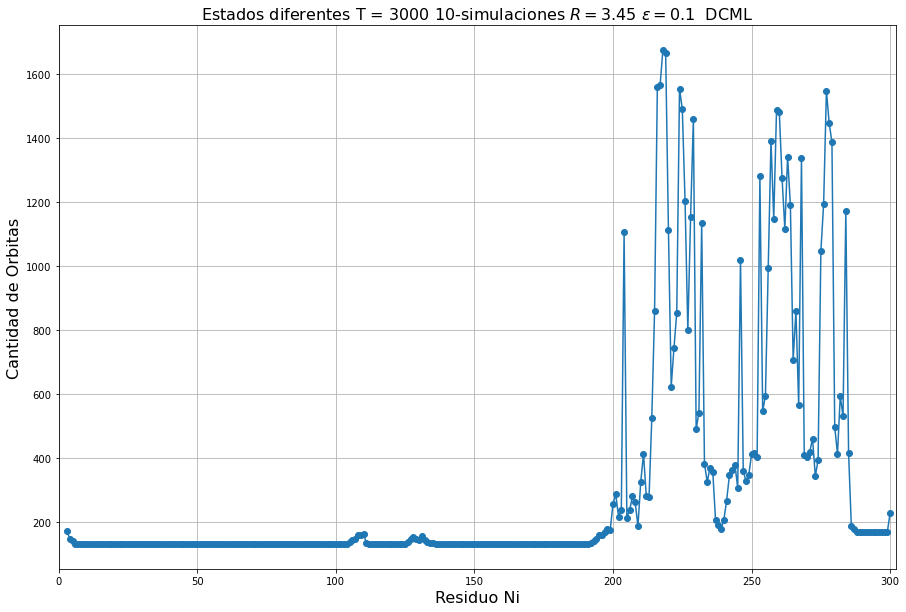

In [104]:
r.count_unique_elements_m(10) # Cuenta las orbitas por cada nodo de la red de M copias del sistema

## T de Fourier

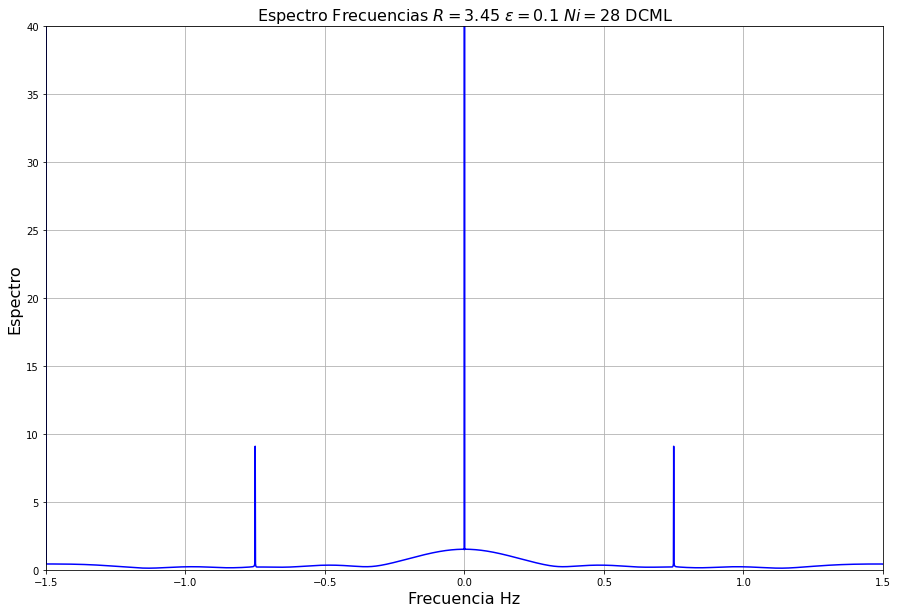

In [105]:
r.TfourierNi(Ni)   #T de fourier de Ni

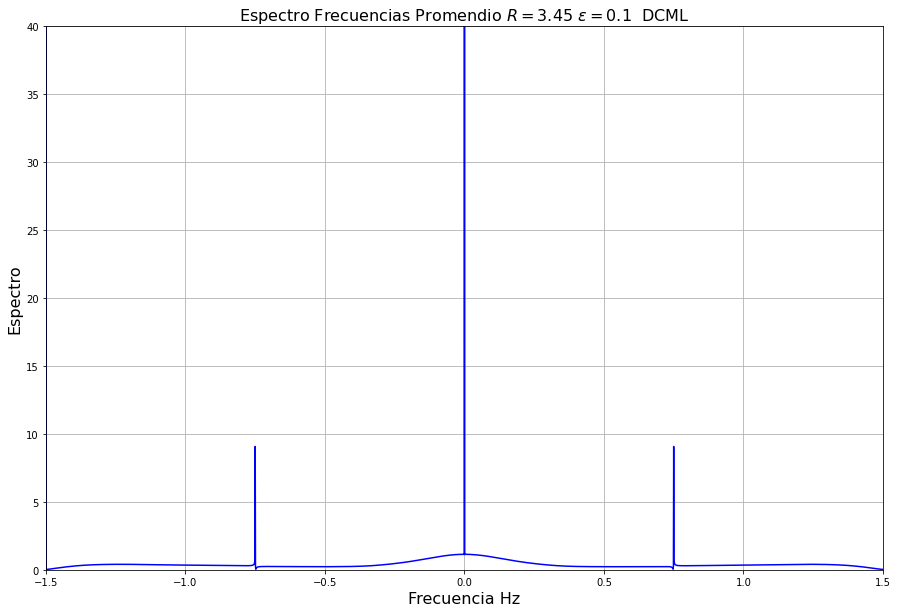

In [106]:
r.Tfourier()    #T de fourier prom

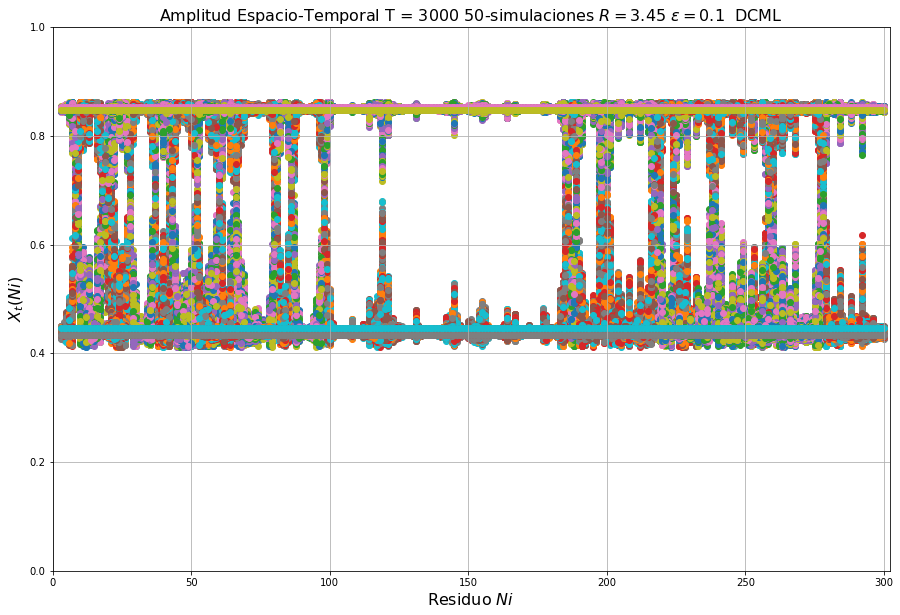

In [116]:
r.AmplitudEspacioTemporalM(50) 

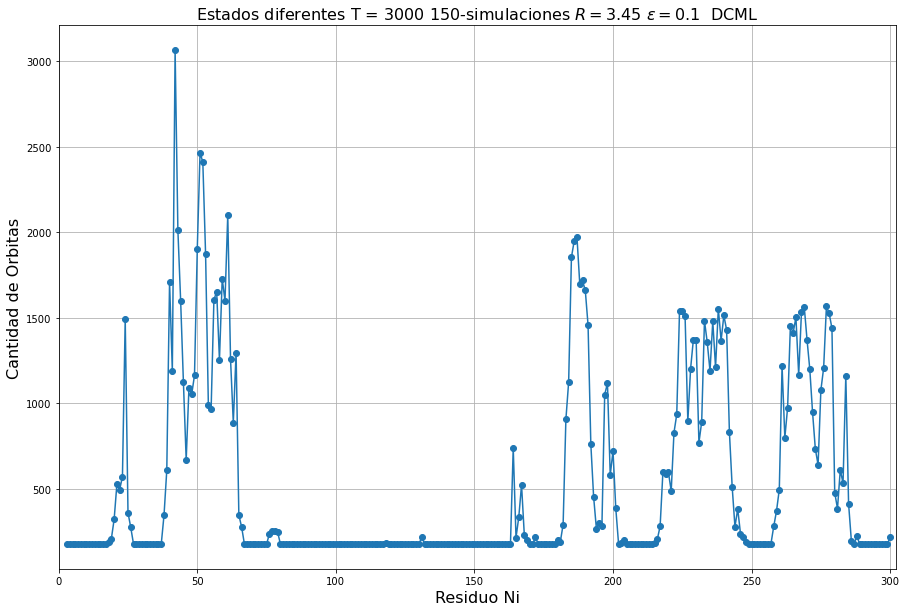

In [121]:
r.count_unique_elements_m(150)